In [1]:
#run this in conda cmd before jupyter: jupyter nbextension enable --py widgetsnbextension
import numpy as np
from pathlib import Path
import pathlib
from os import listdir
from os.path import isfile, join, exists
import json
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops, regionprops_table
from skimage import io
from skimage.transform import resize

import pylab

# %matplotlib inline 
%matplotlib widget 
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import ImageAnalysis
import Morphology
import cv2 
from skimage.exposure import histogram
from skimage.filters import apply_hysteresis_threshold

import pandas as pd

In [2]:
input_data_path = "C:\\RESEARCH\Mitophagy_data\\Testing Input data\\"
list_of_files = [(input_data_path + f, f) for f in listdir(input_data_path) if isfile(join(input_data_path, f))]

In [3]:
def read_sample(image_path):
    sample = io.imread(image_path)
    if sample.shape[-1] == 3:
        return np.mean(sample, axis=-1).astype('uint8')
    else:
        return sample

In [4]:
sample0 = 0
initial_sample = read_sample(list_of_files[sample0][0])
initial_name = list_of_files[sample0][1]
z0 = int((initial_sample.shape[0]/2)-1)
low_thresh = np.max(initial_sample)
high_thresh = np.max(initial_sample)
threshold_params = {}
mip_view = True
save_path = "C:\\RESEARCH\\Mitophagy_data\\gui params\\test.json"

In [5]:
input_path = "C:\\RESEARCH\\Mitophagy_data\\gui params\\test.json"

def retreive_params():
    if isfile(input_path):
        param_file = open(input_path)
        result = json.load(param_file)
        print(result)
        param_file.close()

In [6]:
def mask_image(image, low, high):
    zero_plane = np.zeros_like(image)
    mask = apply_hysteresis_threshold(image, low, high).astype('int')
    masked = image*mask
    orig_rgb = np.stack((image, image, image), axis=-1)
    thresh_rgb = np.stack((mask*255, zero_plane, zero_plane), axis=-1)
    combined_stack = orig_rgb * 0.6 + thresh_rgb * 0.4
    return masked, combined_stack

In [7]:
def updateThresh(val):
    global masked_image
    global mask_overlay
    global z0
    global threshold_params
    global initial_name
    low_thresh = low_slide.val
    high_thresh = high_slide.val
    if low_thresh > high_thresh:
        low_thresh = high_thresh
        low_slide.set_val(low_thresh)
    threshold_params[initial_name] = {"low":low_thresh, "high":high_thresh}
    z0 = z_slide.val
    masked_image, mask_overlay = mask_image(initial_sample, low_thresh, high_thresh)
    ax1.cla()
    ax2.cla()
    ax1.imshow(display_image(masked_image))
    ax2.imshow(display_image(mask_overlay/255))
    ax1.axis('off')
    ax2.axis('off')

def updateZ(val):
    global masked_image
    global mask_overlay
    global z0
    z0 = z_slide.val
    ax1.cla()
    ax2.cla()
    ax1.imshow(display_image(masked_image))
    ax2.imshow(display_image(mask_overlay/255))
    ax1.axis('off')
    ax2.axis('off')

def updateSample(event):
    global sample0
    global initial_sample
    global initial_name
    global z0
    global low_thresh
    global high_thresh
    global threshold_params
    fig1.suptitle(initial_name)
    sample0 = sample_slide.val
    initial_sample = read_sample(list_of_files[sample0][0])
    initial_name = list_of_files[sample0][1]
    sample_min = np.min(initial_sample)
    sample_max = np.max(initial_sample)
    sample_slices = initial_sample.shape[0]
    low_slide.valmin = sample_min
    high_slide.valmin = sample_min
    low_slide.valmax = sample_max
    high_slide.valmax = sample_max
    z_slide.valmax = sample_slices-1
    if initial_name in threshold_params:
        low_slide.valinit = threshold_params[initial_name]['low']
        high_slide.valinit = threshold_params[initial_name]['high']
    else:
        low_slide.valinit = sample_min
        high_slide.valinit = sample_min + (sample_max-sample_min)/2
    z_slide.valinit = abs(int((sample_slices/2)-1))
    low_slide.reset()
    high_slide.reset()
    z_slide.reset()
    z0 = abs(int((sample_slices/2)-1))
    low_thresh = sample_min
    high_thresh = sample_min + (sample_max-sample_min)/2
    masked_image, mask_overlay = mask_image(initial_sample, low_thresh, high_thresh)
    ax1.imshow(display_image(masked_image))
    ax2.imshow(display_image(mask_overlay/255))
    ax1.axis('off')
    ax2.axis('off')


def updateMIP(label):
    global mip_view
    global masked_image
    global mask_overlay
    if label == "MIP":
        mip_view = True
    else:
        mip_view = False
    ax1.imshow(display_image(masked_image))
    ax2.imshow(display_image(mask_overlay/255))
    ax1.axis('off')
    ax2.axis('off')

def display_image(image):
    global mip_view
    global z0
    if mip_view:
        return np.amax(image, axis=0)
    else:
        return image[z0]

def save_params():
    global threshold_params
    global save_path
    with open(save_path, 'w') as j:
        json.dump(threshold_params, j)
    return

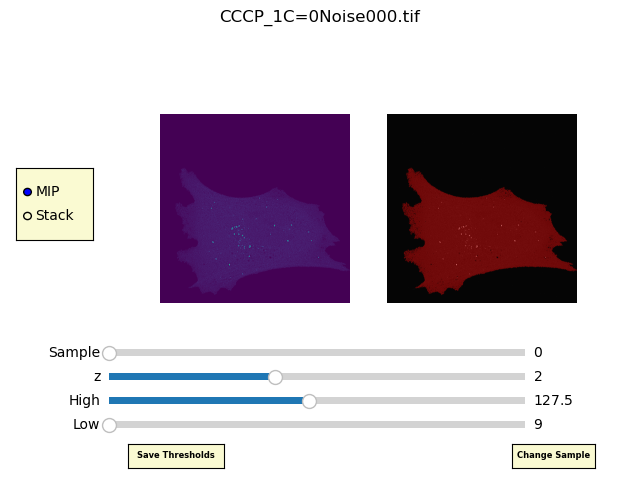

In [8]:
sample0 = 0
initial_sample = read_sample(list_of_files[sample0][0])
initial_name = list_of_files[sample0][1]
z0 = int((initial_sample.shape[0]/2)-1)
low_thresh = np.max(initial_sample)
high_thresh = np.max(initial_sample)
# threshold_params = {}
retreive_params()
fig1, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=0.25, bottom=0.25)
fig1.suptitle(initial_name)

axcolor = 'lightgoldenrodyellow'
axLow = plt.axes([0.17, 0.1, 0.65, 0.03], facecolor=axcolor)
axHigh = plt.axes([0.17, 0.15, 0.65, 0.03], facecolor=axcolor)
axZ = plt.axes([0.17, 0.2, 0.65, 0.03], facecolor=axcolor)
axSample = plt.axes([0.17, 0.25, 0.65, 0.03], facecolor=axcolor)
mipax = plt.axes([0.025, 0.5, 0.12, 0.15], facecolor=axcolor)
axSave = plt.axes([0.2, 0.025, 0.15, 0.05])
button_ax1 = plt.axes([0.8, 0.025, 0.13, 0.05])

if initial_name in threshold_params:
    low_init = threshold_params[initial_name]['low']
    high_init = threshold_params[initial_name]['high']
    print(low_init, high_init)
else:
    low_init = np.min(initial_sample)
    high_init = high_thresh/2

sample_slide = pylab.Slider(axSample, 'Sample', 0, len(list_of_files), valinit=0, valstep = 1)
low_slide = pylab.Slider(axLow, 'Low', np.min(initial_sample), np.max(initial_sample), valinit=low_init)
high_slide = pylab.Slider(axHigh, 'High', np.min(initial_sample), np.max(initial_sample), valinit=high_init)
z_slide = pylab.Slider(axZ, 'z', 0, initial_sample.shape[0] - 1, valinit=int((initial_sample.shape[0]/2)-1), valstep = 1)
saveButton = pylab.Button(axSave, 'Save Thresholds', color=axcolor, hovercolor='0.975')
saveButton.label.set_fontsize(6)
saveButton.label.set_fontweight('bold')
sampleButton = pylab.Button(button_ax1, 'Change Sample', color=axcolor, hovercolor='0.975')
sampleButton.label.set_fontsize(6)
sampleButton.label.set_fontweight('bold')
mip_switch = RadioButtons(mipax, ('MIP', 'Stack'), active=0)
masked_image, mask_overlay = mask_image(initial_sample, low_slide.val, high_slide.val)
ax1.imshow(display_image(masked_image))
ax2.imshow(display_image(mask_overlay/255))
ax1.axis('off')
ax2.axis('off')

low_slide.on_changed(updateThresh)
high_slide.on_changed(updateThresh)
z_slide.on_changed(updateZ)
sampleButton.on_clicked(updateSample)
mip_switch.on_clicked(updateMIP)
saveButton.on_clicked(save_params)

plt.show()

In [9]:
print(threshold_params)

{}


In [ ]:
sample1 = 0